In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import os
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import glob 

EPOCHS = 12
LAYERS = 2

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
DATA_DIR = "Data/COVID-19_Radiography_Dataset"
DATA_DIR = pathlib.Path(DATA_DIR)

In [4]:
img_height = 64
img_width = 64
batch_size = 16 
input_shape = (img_height, img_width, 3)

In [5]:
train_datagen = ImageDataGenerator()

In [6]:
image_count = len(list(DATA_DIR.glob("*/*.png")))

In [7]:
dataset_fraction = 0.25
test_fraction = 0.2
validate_fraction = 0.2

In [8]:
def get_train_validate_test_sizes(
    image_count, 
    dataset_fraction, 
    test_fraction, 
    validate_fraction
):
    image_count = int(dataset_fraction * image_count)
    test_size = int(image_count * test_fraction)
    training = image_count - test_size
    validate_size = int(validate_fraction * training)
    train_size =  training - validate_size
    
    return train_size, validate_size, test_size

In [9]:
train_size, validate_size, test_size = get_train_validate_test_sizes(
    image_count, 
    dataset_fraction, 
    test_fraction, 
    validate_fraction
)

train_size, validate_size, test_size

(2210, 552, 690)

In [10]:
def get_all_files(directory, image_count):
    list_ds = tf.data.Dataset.list_files(str(directory/'*/*'), shuffle=False)
    list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
    
    return list_ds

In [11]:
def get_class_names(directory):
    return list(sorted([item.name for item in directory.glob('*') if item.is_dir()]))

In [12]:
class_names = get_class_names(DATA_DIR)

In [13]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)


In [14]:
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [15]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [16]:
def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [17]:
def get_train_validate_test(
    directory,
    image_count,
    train_val_test_sizes,
    batch_size
):
    train_size, validate_size, test_size = train_val_test_sizes
    
    list_ds = get_all_files(directory, image_count)
    
    train_ds = list_ds.take(train_size)
    val_ds = list_ds.take(validate_size)
    test_ds = list_ds.take(test_size)
    
#     for dataset in [train_ds, val_ds, test_ds]:
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    train_ds = configure_for_performance(train_ds, batch_size)

    val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = configure_for_performance(val_ds, batch_size)

    test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = configure_for_performance(test_ds, batch_size)
    
    return train_ds, val_ds, test_ds

In [18]:
def plot_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 100))
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        ax = plt.subplot(batch_size, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[label])
        plt.axis("off")


In [19]:
train_ds, val_ds, test_ds = get_train_validate_test(
    DATA_DIR,
    image_count,
    (train_size, validate_size, test_size),
    batch_size
)

In [20]:
image_batch, label_batch = next(iter(train_ds))
test_image_batch, test_label_batch = next(iter(test_ds))

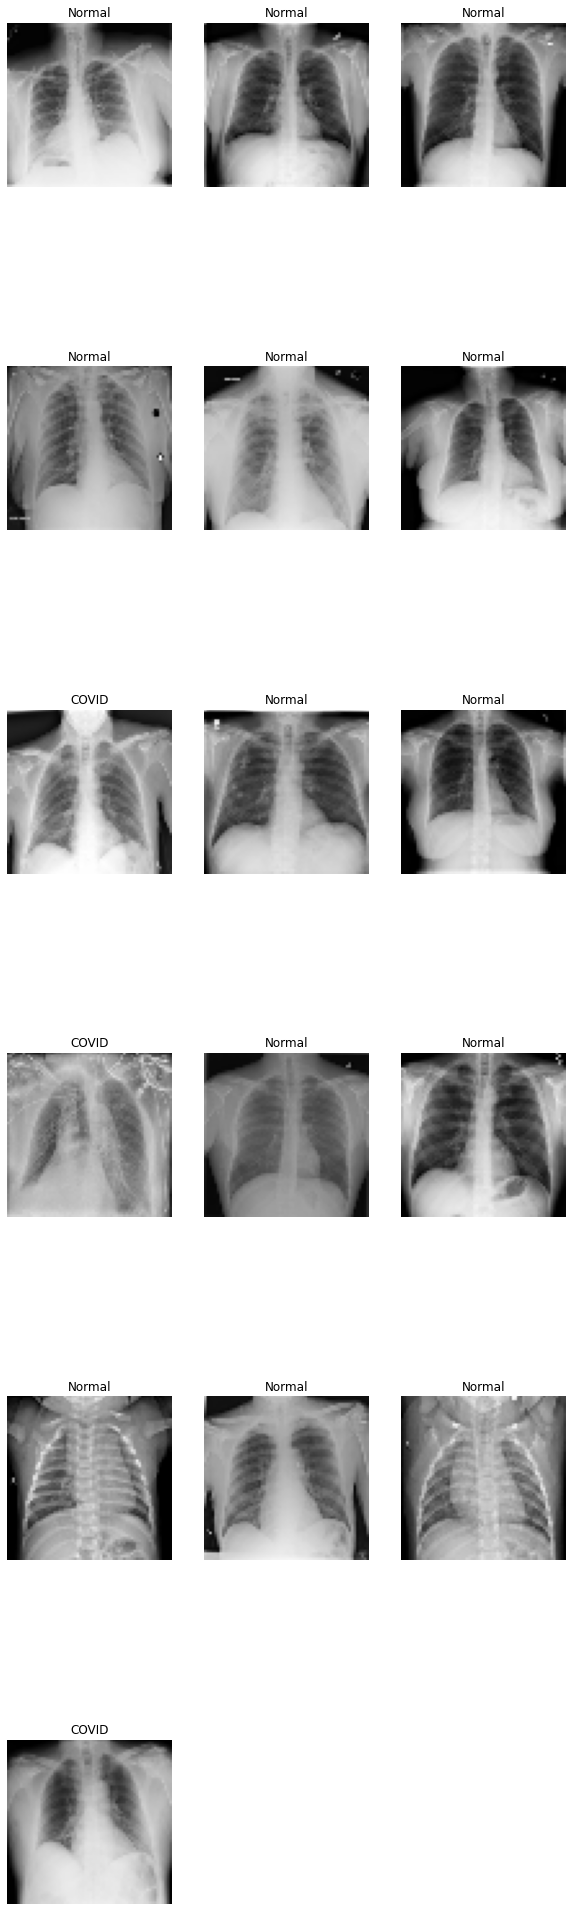

In [21]:
plot_batch(image_batch, label_batch, class_names)

In [22]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.1),
    ]
)

classes = 2
inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
# Rescale image values to [0, 1]
x = preprocessing.Rescaling(1.0 / 255)(x)


In [23]:
resnet = tf.keras.applications.ResNet50(
    weights="imagenet", input_shape=input_shape,
    include_top=False
)
resnet.trainable = False
for i in range(1, LAYERS+1):
    resnet.layers[-i].trainable = True
x = resnet(x, training=False)

# vgg = VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=input_shape
#     )
# vgg.trainable = False
# x = vgg(x, training=False)

In [24]:
from tensorflow.keras.optimizers import Adam

In [25]:
def get_own_model():
    model=tf.keras.Sequential()
#     model.add(preprocessing.Rescaling(1.0 / 255))
    model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16))
    model.add(tf.keras.layers.Dropout(.15, input_shape=(16,)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

In [26]:
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)

In [27]:
model = get_own_model()


In [28]:
# model = Model(inputs, x)

In [29]:
model.compile( loss='binary_crossentropy',
               optimizer=Adam(learning_rate=0.0001),
               metrics=['accuracy']
             )
history = model.fit(train_ds, validation_data=val_ds,
           batch_size=batch_size, epochs=EPOCHS, verbose=1)

Epoch 1/12
139/139 [==============================] - 8s 44ms/step - loss: 2.9140 - accuracy: 0.7290 - val_loss: 1.0706 - val_accuracy: 0.7591
Epoch 2/12
139/139 [==============================] - 5s 39ms/step - loss: 0.8730 - accuracy: 0.7986 - val_loss: 0.7049 - val_accuracy: 0.8243
Epoch 3/12
139/139 [==============================] - 7s 50ms/step - loss: 0.6336 - accuracy: 0.8362 - val_loss: 0.3403 - val_accuracy: 0.8659
Epoch 4/12
139/139 [==============================] - 6s 41ms/step - loss: 0.4954 - accuracy: 0.8529 - val_loss: 0.3521 - val_accuracy: 0.8587
Epoch 5/12
139/139 [==============================] - 4s 30ms/step - loss: 0.5229 - accuracy: 0.8579 - val_loss: 0.2655 - val_accuracy: 0.9004
Epoch 6/12
139/139 [==============================] - 4s 27ms/step - loss: 0.3268 - accuracy: 0.8891 - val_loss: 0.1898 - val_accuracy: 0.9275
Epoch 7/12
139/139 [==============================] - 5s 35ms/step - loss: 0.2737 - accuracy: 0.9109 - val_loss: 0.2444 - val_accuracy: 0.9040

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                100368    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

In [31]:
df = pd.DataFrame(history.history)
df.index += 1
df.index.name = "epoch"
df

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,2.913992,0.728959,1.070578,0.759058
2,0.872966,0.798643,0.704894,0.824275
3,0.633584,0.836199,0.340312,0.865942
4,0.495435,0.852941,0.352092,0.858696
5,0.522920,0.857919,0.265468,0.900362
6,0.326765,0.889140,0.189797,0.927536
7,0.273731,0.910860,0.244395,0.903986
8,0.300401,0.898190,0.145099,0.940217
9,0.213974,0.919457,0.140301,0.942029


In [32]:
score = model.evaluate(val_ds, verbose=0)

print(f"\nepochs = {EPOCHS}")
print("score = {:.2f}%\n".format(score[1]*100))


epochs = 12
score = 93.48%



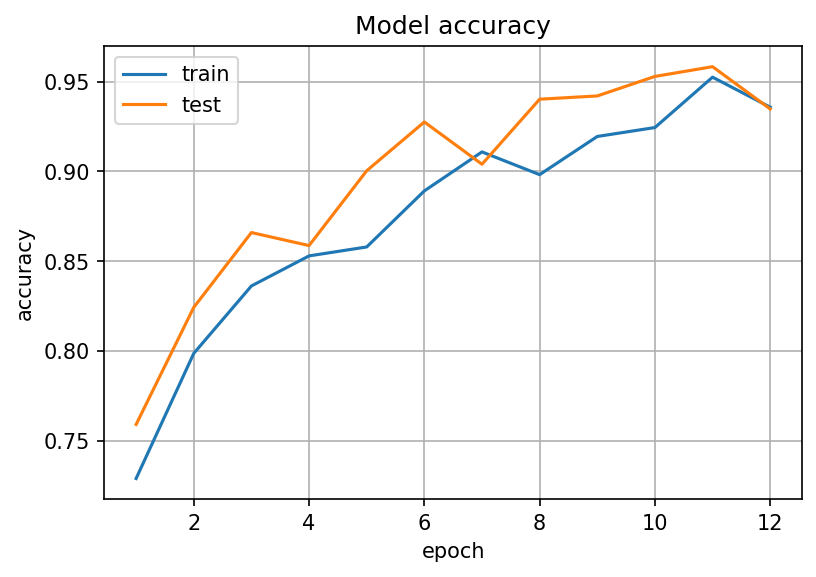

In [33]:
plt.figure(dpi=150)
plt.plot(df["accuracy"])
plt.plot(df["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.grid()
plt.legend(["train", "test"], loc="upper left")
ax = plt.gca()
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

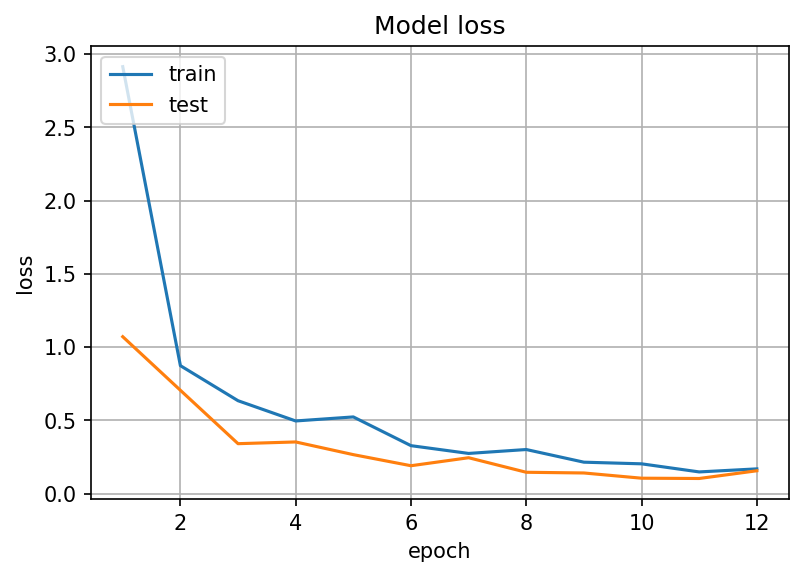

In [34]:
plt.figure(dpi=150)
plt.plot(df["loss"])
plt.plot(df["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.grid()
plt.legend(["train", "test"], loc="upper left")
ax = plt.gca()
ax.xaxis.get_major_locator().set_params(integer=True)
plt.show()

In [53]:
tfds.benchmark(test_ds, batch_size=batch_size)

  2%|2         | 1/44 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 6838.16 ex/sec (total: 704 ex, 0.10 sec)
Examples/sec (First only) 647.35 ex/sec (total: 16 ex, 0.02 sec)
Examples/sec (First excluded) 8793.94 ex/sec (total: 688 ex, 0.08 sec)


,duration,num_examples,avg
first+lasts,0.102952,704,6838.157224
first,0.024716,16,647.353024
lasts,0.078236,688,8793.941813


In [54]:
true_labels = []
imgs = []

In [55]:
for image, label in test_ds.unbatch().as_numpy_iterator():
    imgs.append(image)
    true_labels.append(label)

In [56]:
true_labels = np.array(true_labels).astype('int32')
imgs = np.array(imgs)

In [57]:
pred = model.predict(imgs)

In [58]:
pred_rounded = np.round(pred)

In [59]:
model.evaluate(test_ds)

44/44 [==============================] - 1s 15ms/step - loss: 0.1477 - accuracy: 0.9391


[0.14771012961864471, 0.939130425453186]

In [60]:
conf = tf.math.confusion_matrix(true_labels, pred_rounded)
conf

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[182,   1],
       [ 41, 466]], dtype=int32)>

In [61]:
accuracy = np.trace(conf.numpy())/np.sum(conf.numpy())* 100
accuracy

93.91304347826087

In [62]:
acc = tf.keras.metrics.BinaryAccuracy(
    name='binary_accuracy', dtype=None, threshold=0.5
)

In [63]:
acc.reset_state()

In [64]:
acc.update_state(true_labels, pred)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [65]:
acc.result().numpy()*100

93.9130425453186

In [51]:
def plot_predictions(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 100))
    batch_size = image_batch.shape[0]
    for i in range(batch_size):
        ax = plt.subplot(batch_size, 3, i + 1)
        image = image_batch[i]
        plt.imshow(image.numpy().astype("uint8"))
        label = label_batch[i]
        predicted = round(model.predict(tf.expand_dims(image, axis=0))[0][0])
        plt.title("True: " + class_names[label] +"\nPrediction: " + class_names[predicted])
        plt.axis("off")

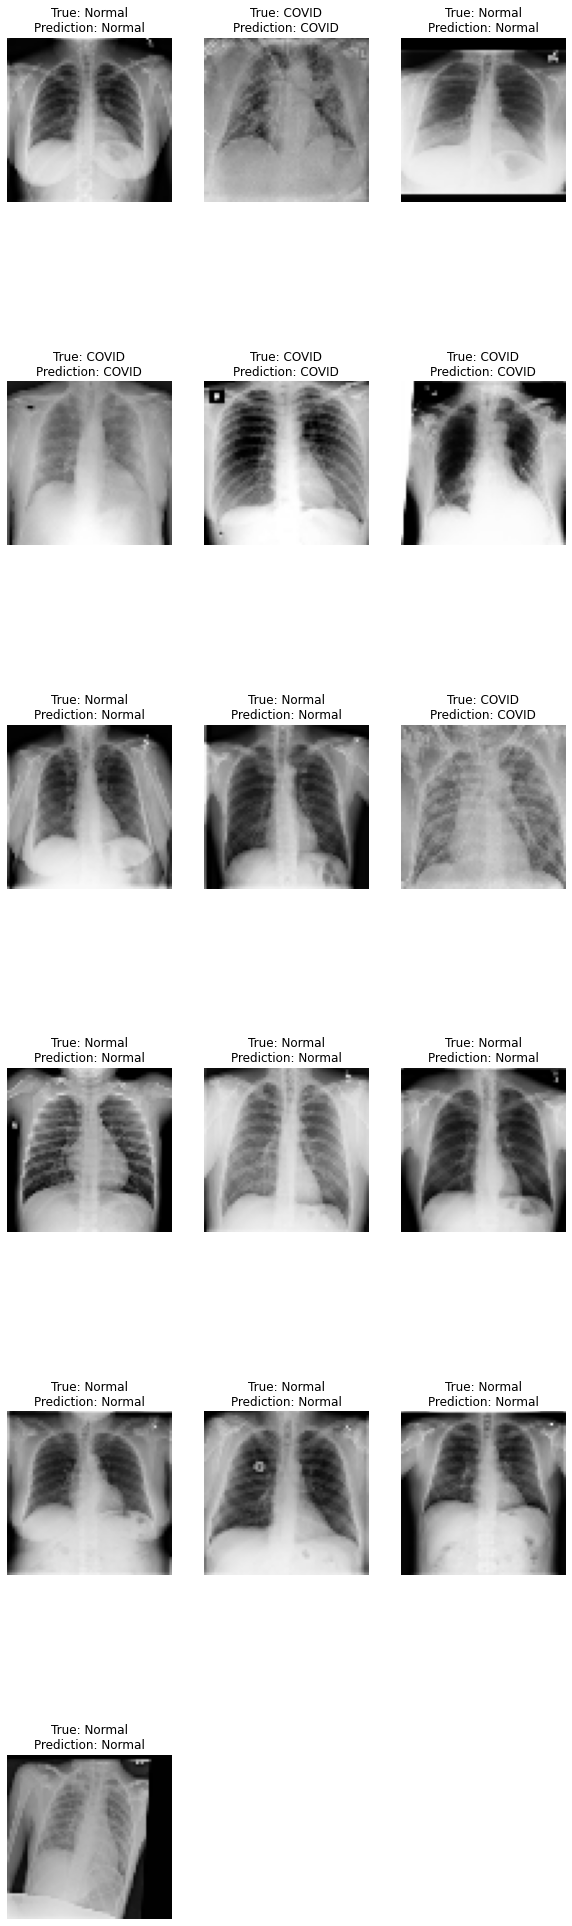

In [52]:
plot_predictions(test_image_batch, test_label_batch, class_names)